In [1]:
import configparser
import json
import spotipy
import spotipy.util as util
import pandas as pd
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
import bamboolib
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [92]:
with open('../data/raw/spotify_creds.json') as f:
    spotify_creds = json.load(f)

with open('../data/raw/spotify_token.json') as f:
    spotify_token = json.load(f)

client_id = spotify_creds['client_id']
client_secret = spotify_creds['client_secret']
username = spotify_creds['username']
scope = spotify_creds['saved_library_scope']
redirect_uri = spotify_creds['saved_library_redirect_url']
#token = spotify_token['all_access_token']


def connect_to_spotify_api(client_id, client_secret, username, scope, redirect_uri):
    
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
    if token:
        sp = spotipy.Spotify(auth=token)
    else:
        print("Can't get token for", username)
        
    return sp

sp = connect_to_spotify_api(client_id, client_secret, username, scope, redirect_uri)

In [49]:
def get_saved_library():
    
    df_saved_tracks = pd.DataFrame()
    track_list = ''
    added_ts_list = []
    artist_list = []
    artist_url_list = []
    title_list = []
    popularity_list = []
    album_cover_list = []
    track_url_list = []
    more_songs = True
    offset_index = 0

    while more_songs:
        songs = sp.current_user_saved_tracks(offset=offset_index)
        for song in songs['items']:
            #join track ids to a string for audio_features function
            track_list += song['track']['id'] +','
            #get the time when the song was added
            added_ts_list.append(song['added_at'])
            #get the title of the song
            title_list.append(song['track']['name'])
            #get popularity
            popularity_list.append(song['track']['popularity'])
            album_cover_list.append(song['track']['album']['images'][0]['url'])
            # get track list
            track_url = song['track']['external_urls']['spotify']
            track_url = track_url.split('/')[-1]
            track_url_list.append(track_url)
            #get all the artists in the song
            artists = song['track']['artists']
            artists_name = ''
            for artist in artists:
                artists_name += artist['name']  + ','
            artist_list.append(artists_name[:-1])
            # aritst_url
            artists = song['track']['artists']
            artists_urls = ''
            for artist in artists:
                artist_url = artist['external_urls']['spotify']
                artist_url = artist_url.split('/')[-1]
                artists_urls += artist_url  + ','
            artist_url_list.append(artists_urls[:-1])
            
        track_features = sp.audio_features(track_list[:-1])
        df_temp = pd.DataFrame(track_features)
        df_temp = df_temp[['acousticness', 'danceability', 'energy', 'speechiness', 'valence', 'tempo']]
        df_temp = df_temp.rename(columns={'tempo': 'BPM'})
        df_saved_tracks = df_saved_tracks.append(df_temp)
        track_list = ''
        if songs['next'] == None:
            # no more songs in playlist
            more_songs = False
        else:
            # get the next n songs
            offset_index += songs['limit']
    #include timestamp added, title and artists of a song
    df_saved_tracks['song_title'] = title_list
    df_saved_tracks['artists'] = artist_list
    df_saved_tracks['artists_url'] = artist_url_list
    df_saved_tracks['date_added'] = added_ts_list
    df_saved_tracks['album_cover'] = album_cover_list
    df_saved_tracks['popularity'] = popularity_list
    df_saved_tracks['date_added'] = df_saved_tracks['date_added'].apply(lambda x: x.split('T')[0])
    df_saved_tracks['url'] = track_url_list
    df_saved_tracks['date_added'] = pd.to_datetime(df_saved_tracks['date_added'], infer_datetime_format=True)
    df_saved_tracks['date_added_year'] = df_saved_tracks['date_added'].dt.year
    
    return df_saved_tracks

In [93]:
df_saved = get_saved_library()
#df_saved[['BPM']] = NormalizeData(df_saved[['BPM']])

In [61]:
df_saved.to_csv('df_saved.csv',index=False)

In [111]:
def get_all_genre(df):
    artist_list = []

    for i in range(len(df_saved)):
        artists = df_saved.iloc[i]['artists_url']
        for artist in artists.split(','):
            artist_list.append(artist)

    artist_list = set(artist_list)
    
    df_artist_genre = pd.DataFrame()
    aritst_name_list = []
    aritst_genre_list = []

    for i in artist_list:
        aritst_name = sp.artist(i)['name']
        #print(aritst_name)
        aritst_genre = sp.artist(i)['genres']
        aritst_name_list.append(aritst_name)
        aritst_genre_list.append(aritst_genre)

    df_artist_genre['name'] = aritst_name_list
    df_artist_genre['genre'] = aritst_genre_list
    
    df_artist_detailed_genre = pd.DataFrame()
    aritst_name_list = []
    aritst_genre_list = []

    for i in range(len(df_artist_genre)):
        artist = df_artist_genre.iloc[i]['name']
        genre_list = df_artist_genre.iloc[i]['genre']
        for genre in genre_list:
            aritst_name_list.append(artist)
            aritst_genre_list.append(genre)

    df_artist_detailed_genre['name'] = aritst_name_list
    df_artist_detailed_genre['genre'] = aritst_genre_list
    
    return df_artist_detailed_genre

In [112]:
df = get_all_genre(df_saved)

In [101]:
genre_new = []

for i in range(len(df_artist_detailed_genre)):
    genre = df_artist_detailed_genre.iloc[i]['genre']
    if 'pop' in genre:
        genre_new.append('pop')
    elif 'edm' in genre:
        genre_new.append('edm')
    elif 'house' in genre:
        genre_new.append('house')
    elif 'big room' in genre:
        genre_new.append('big room')
    elif 'trance' in genre:
        genre_new.append('trance')
    elif 'elect' in genre:
        genre_new.append('edm')
    elif 'rap' in genre:
        genre_new.append('rap')
    elif 'dance' in genre:
        genre_new.append('dance')
    else:
        genre_new.append('other')
        
df_artist_detailed_genre['genre_new'] = genre_new

In [99]:
df_artist_detailed_genre

,name,genre,genre_new
0,Tony Junior,big room,other
1,Tony Junior,deep big room,other
2,Tony Junior,dutch house,house
3,Tony Junior,edm,edm
4,Tony Junior,electro house,house
...,...,...,...
2776,RANI,uk pop,pop
2777,SHY Martin,alt z,other
2778,SHY Martin,electropop,pop
2779,SHY Martin,pop,pop


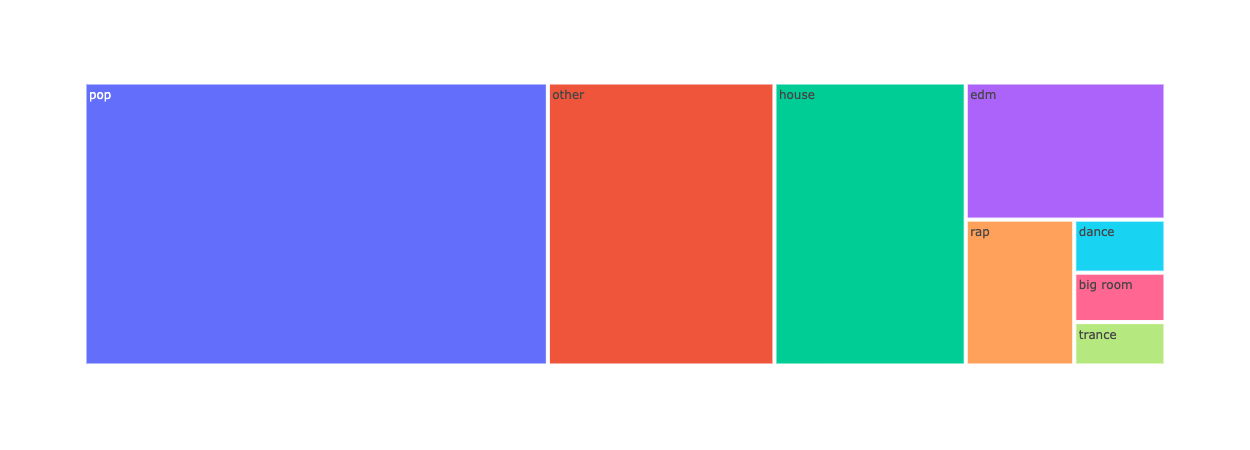

In [110]:
import plotly.express as px
fig = px.treemap(df_artist_detailed_genre, path=['genre_new'])
fig